In [73]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.utils import sharpe_ratio, max_drawdown

In [74]:
# load data
ticker1 = "SPY"
ticker2 = "IVV"

prices = pd.read_csv("../data_raw/prices.csv", index_col=0, parse_dates=True).dropna()
features = pd.read_csv("../data_processed/features.csv", index_col=0, parse_dates=True).dropna()
pred = pd.read_csv("../data_processed/predictions.csv", index_col=0, parse_dates=True).dropna()

# Align everything by date intersection (prevents all index mismatch bugs)
idx = prices.index.intersection(features.index).intersection(pred.index)

prices = prices.loc[idx, [ticker1, ticker2]]
features = features.loc[idx]
pred = pred.loc[idx]

prices.shape, features.shape, pred.shape

((1256, 2), (1256, 16), (1256, 3))

In [75]:
beta = float(features["beta"].iloc[0])  # constant beta column

ret1 = prices[ticker1].pct_change()
ret2 = prices[ticker2].pct_change()

spread_ret = (ret2 - beta * ret1).rename("spread_ret")
spread_ret = spread_ret.loc[idx]  # align
spread_ret.head()

Date
2020-12-31         NaN
2021-01-04   -0.000253
2021-01-05   -0.000222
2021-01-06    0.000101
2021-01-07    0.000049
Name: spread_ret, dtype: float64

In [76]:
# Rules:

# long spread if z < -2

# short spread if z > +2

# exit to flat when z crosses 0
z = features["z_score"]

entry_z = 2.0
exit_z = 0.0

baseline_pos = pd.Series(0, index=z.index, name="baseline_pos")
baseline_pos[z < -entry_z] = 1
baseline_pos[z > entry_z] = -1

# hold until exit
baseline_pos = baseline_pos.replace(to_replace=0, method="ffill").fillna(0)

# exits
baseline_pos[(baseline_pos == 1) & (z >= exit_z)] = 0
baseline_pos[(baseline_pos == -1) & (z <= -exit_z)] = 0

# hold again after exits
baseline_pos = baseline_pos.replace(to_replace=0, method="ffill").fillna(0)

baseline_pos.tail()

baseline_ret = (baseline_pos.shift(1) * spread_ret).rename("baseline_ret").fillna(0)
baseline_eq = (1 + baseline_ret).cumprod().rename("baseline_eq")

/var/folders/3g/lbd99xz94p179sd0d5kgsb6r0000gp/T/ipykernel_1765/3379388339.py:18: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  baseline_pos = baseline_pos.replace(to_replace=0, method="ffill").fillna(0)
/var/folders/3g/lbd99xz94p179sd0d5kgsb6r0000gp/T/ipykernel_1765/3379388339.py:25: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  baseline_pos = baseline_pos.replace(to_replace=0, method="ffill").fillna(0)


In [77]:
# apply the model predictions
proba = pred["proba"]

proba_threshold = 0.55

ml_pos = pd.Series(0, index=z.index, name="ml_pos")
ml_pos[(z < -entry_z) & (proba > proba_threshold)] = 1
ml_pos[(z > entry_z) & (proba > proba_threshold)] = -1

# Optional: hold positions until exit like baseline
ml_pos = ml_pos.replace(to_replace=0, method="ffill").fillna(0)
ml_pos[(ml_pos == 1) & (z >= exit_z)] = 0
ml_pos[(ml_pos == -1) & (z <= -exit_z)] = 0
ml_pos = ml_pos.replace(to_replace=0, method="ffill").fillna(0)

ml_ret = (ml_pos.shift(1) * spread_ret).rename("ml_ret").fillna(0)
ml_eq = (1 + ml_ret).cumprod().rename("ml_eq")


/var/folders/3g/lbd99xz94p179sd0d5kgsb6r0000gp/T/ipykernel_1765/1352386784.py:11: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  ml_pos = ml_pos.replace(to_replace=0, method="ffill").fillna(0)
/var/folders/3g/lbd99xz94p179sd0d5kgsb6r0000gp/T/ipykernel_1765/1352386784.py:14: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  ml_pos = ml_pos.replace(to_replace=0, method="ffill").fillna(0)


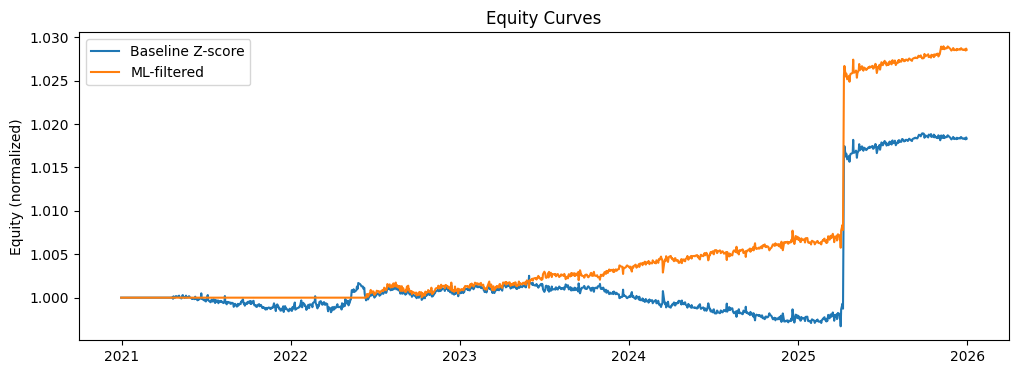

      strategy    sharpe  max_drawdown  total_return  trades  active_days
0     baseline  0.519235     -0.005799      0.018314       5         1184
1  ml_filtered  0.840226     -0.002026      0.028545       4          892


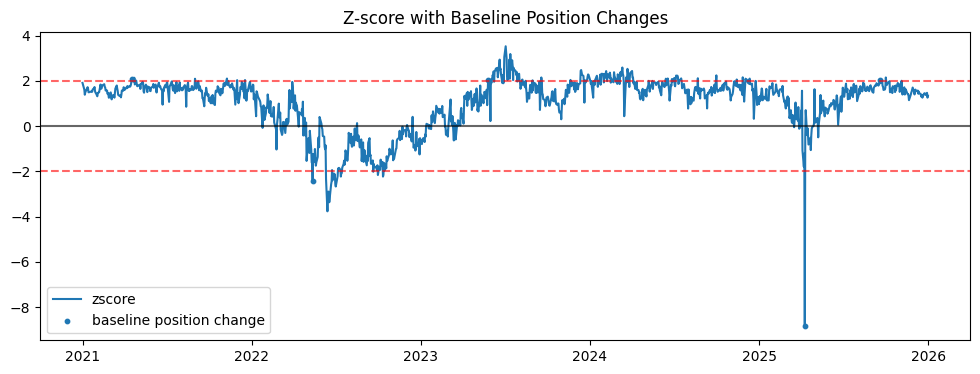

In [78]:
# Plot portfolio performance

plt.figure(figsize=(12,4))
plt.plot(baseline_eq.index, baseline_eq.values, label="Baseline Z-score")
plt.plot(ml_eq.index, ml_eq.values, label="ML-filtered")
plt.title("Equity Curves")
plt.ylabel("Equity (normalized)")
plt.legend()
plt.show()

def summarize(name, r, eq, pos):
    sr = sharpe_ratio(r)
    mdd = max_drawdown(eq)
    trades = int((pos.diff().fillna(0) != 0).sum())
    active_days = int((pos != 0).sum())
    return {
        "strategy": name,
        "sharpe": sr,
        "max_drawdown": mdd,
        "total_return": float(eq.iloc[-1] - 1),
        "trades": trades,
        "active_days": active_days
    }

summary = pd.DataFrame([
    summarize("baseline", baseline_ret, baseline_eq, baseline_pos),
    summarize("ml_filtered", ml_ret, ml_eq, ml_pos)
])

print(summary)

plt.figure(figsize=(12,4))
plt.plot(z.index, z.values, label="zscore")
plt.axhline(2, color="red", linestyle="--", alpha=0.6)
plt.axhline(-2, color="red", linestyle="--", alpha=0.6)
plt.axhline(0, color="black", alpha=0.6)

# mark entry points (baseline)
entries = baseline_pos.diff().fillna(0).ne(0)
plt.scatter(z.index[entries], z[entries], s=10, label="baseline position change")

plt.title("Z-score with Baseline Position Changes")
plt.legend()
plt.show()

